In [1]:
import numpy as np
import bilby

In [2]:
from bilby.gw.source import _base_lal_cbc_fd_waveform

In [3]:
import pycbc.conversions

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [5]:
# making a new waveform function to pass to `bilby.gw.WaveformGenerator`

# based on functions in https://git.ligo.org/lscsoft/bilby/-/blob/master/bilby/gw/source.py

In [6]:
def mixed_lal_binary_black_hole(
        frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
        phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, alpha, **kwargs):
    """
    
    look at the function `lal_binary_black_hole`: https://git.ligo.org/lscsoft/bilby/-/blob/master/bilby/gw/source.py#L14
    for docstring.
    
    Here we extend this to generate two waveforms that are aligned and combined with a variable parameter `alpha`
    So two additional arguments are:
        `waveform_approximant_2` and
        `alpha`
        

    Returns
    =======
    dict: A dictionary with the plus and cross polarisation strain modes
    """
    waveform_kwargs = dict(
        waveform_approximant='IMRPhenomPv2', reference_frequency=50.0,
        minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
        catch_waveform_errors=False, pn_spin_order=-1, pn_tidal_order=-1,
        pn_phase_order=-1, pn_amplitude_order=0)
    waveform_kwargs.update(kwargs)
    
    
    waveform_kwargs_2 = waveform_kwargs.copy()
    waveform_kwargs_2['waveform_approximant'] = kwargs['waveform_approximant_2']

    wf1 = _base_lal_cbc_fd_waveform(
            frequency_array=frequency_array, mass_1=mass_1, mass_2=mass_2,
            luminosity_distance=luminosity_distance, theta_jn=theta_jn, phase=phase,
            a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12,
            phi_jl=phi_jl,
            **waveform_kwargs)
    
    wf2 = _base_lal_cbc_fd_waveform(
            frequency_array=frequency_array, mass_1=mass_1, mass_2=mass_2,
            luminosity_distance=luminosity_distance, theta_jn=theta_jn, phase=phase,
            a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12,
            phi_jl=phi_jl,
            **waveform_kwargs_2)
    
    
    wf1_plus_amp = np.abs(wf1['plus'])
    wf2_plus_amp = np.abs(wf2['plus'])
    
    wf1_cross_amp = np.abs(wf1['cross'])
    wf2_cross_amp = np.abs(wf2['cross'])
    
    plus_amp_combined = alpha * wf1_plus_amp + (1-alpha) * wf2_plus_amp
    cross_amp_combined = alpha * wf1_cross_amp + (1-alpha) * wf2_cross_amp
    
    
    wf1_plus_phase = np.unwrap(np.angle(wf1['plus']))
    wf2_plus_phase = np.unwrap(np.angle(wf2['plus']))
    
    wf1_cross_phase = np.unwrap(np.angle(wf1['cross']))
    wf2_cross_phase = np.unwrap(np.angle(wf2['cross']))
    
    plus_phase_combined = alpha * wf1_plus_phase + (1-alpha) * wf2_plus_phase
    cross_phase_combined = alpha * wf1_cross_phase + (1-alpha) * wf2_cross_phase
    
    
    plus_combined = plus_amp_combined * np.exp(1.j * plus_phase_combined)
    cross_combined = cross_amp_combined * np.exp(1.j * cross_phase_combined)
    
    wf_combined = {'plus':plus_combined, 'cross':cross_combined}

    if 'return_all'  in kwargs.keys():
        return wf1, wf2, wf_combined
    else:
        return wf_combined

In [7]:
frequency_array = np.arange(0, 2048, 1/4.)
mass_1 = 100.
mass_2 = 10.
luminosity_distance = 1
a_1 = 0.
tilt_1 = 0.
phi_12 = 0.
a_2 = 0.
tilt_2 = 0.
phi_jl = 0.
theta_jn = 0.
phase = 0. 

alpha = 0.5

# waveform_approximant = "IMRPhenomC"
# waveform_approximant = "SEOBNRv2"
# waveform_approximant = "IMRPhenomXAS"
waveform_approximant = "SEOBNRv4"
waveform_approximant_2 = "IMRPhenomD"

In [8]:
wf1, wf2, wf_combined = mixed_lal_binary_black_hole(
    frequency_array=frequency_array,
    mass_1=mass_1,
    mass_2=mass_2,
    luminosity_distance=luminosity_distance,
    a_1=a_1,
    tilt_1=tilt_1,
    phi_12=phi_12, 
    a_2=a_2, 
    tilt_2=tilt_2, 
    phi_jl=phi_jl, 
    theta_jn=theta_jn, 
    phase=phase,
    waveform_approximant=waveform_approximant,
    waveform_approximant_2=waveform_approximant_2,
    alpha=alpha,
    return_all=True
)

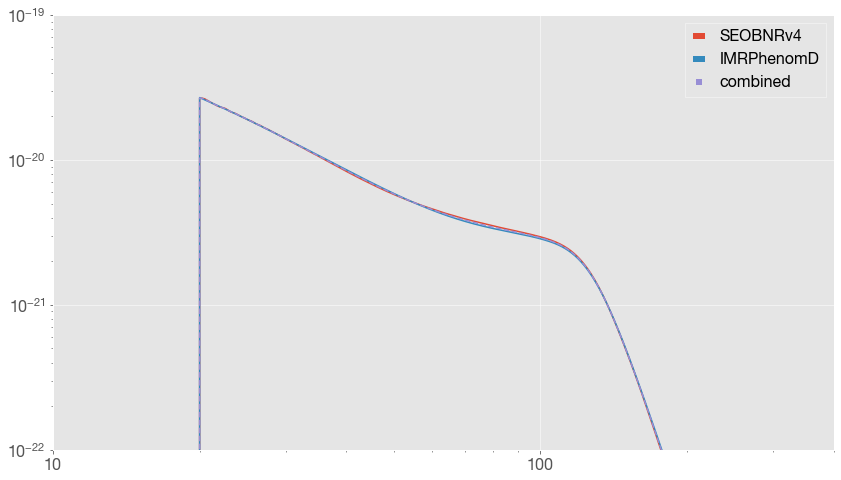

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(frequency_array, np.abs(wf1['plus']), label=waveform_approximant)
plt.plot(frequency_array, np.abs(wf2['plus']), label=waveform_approximant_2)

plt.plot(frequency_array, np.abs(wf_combined['plus']), label='combined', ls='--')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-22, 1e-19)
plt.xlim(10, 400)
plt.legend()

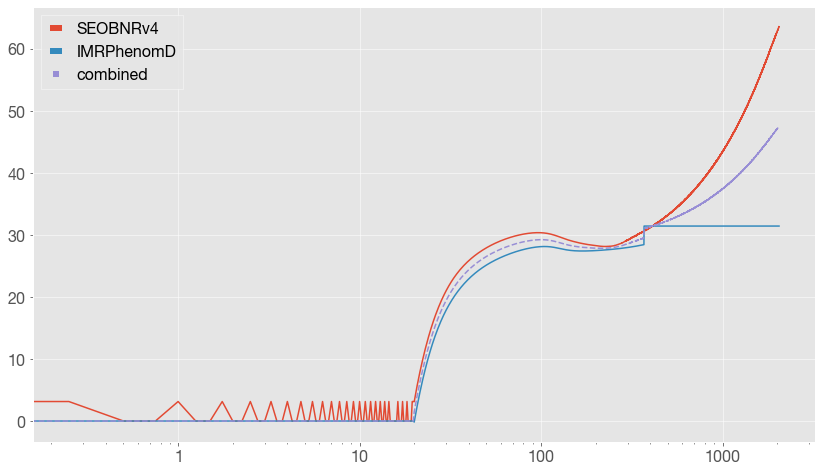

In [10]:
plt.figure(figsize=(14, 8))
plt.plot(frequency_array, np.unwrap(np.angle(wf1['plus'])), label=waveform_approximant)
plt.plot(frequency_array, np.unwrap(np.angle(wf2['plus'])), label=waveform_approximant_2)

plt.plot(frequency_array, np.unwrap(np.angle(wf_combined['plus'])), label='combined', ls='--')

plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-22, 1e-19)
# plt.xlim(10, 400)
plt.legend()

# try some PE

In [13]:
# using the following as a base: https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/injection_examples/fast_tutorial.py

In [247]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.
# sampling_frequency = 2048.
# sampling_frequency = 1024.
sampling_frequency = 512.

# Specify the output directory and the name of the simulation.
outdir = 'mixed_generator_output'
label = 'case0'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

In [248]:
# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

In [249]:
# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0., a_2=0., tilt_1=0., tilt_2=0,
    phi_12=0, phi_jl=0., luminosity_distance=200., theta_jn=0., psi=0,
    phase=0, geocent_time=1126259642.413, ra=1.375, dec=-1.2108, alpha=0.9)

In [250]:
# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant='IMRPhenomC',
    reference_frequency=50., minimum_frequency=40.,
    waveform_approximant_2 = "IMRPhenomD"
)

In [251]:
# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
#     frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    frequency_domain_source_model=mixed_lal_binary_black_hole,    
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

17:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.mixed_lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [252]:
waveform_generator

WaveformGenerator(duration=4.0, sampling_frequency=512.0, start_time=0, frequency_domain_source_model=mixed_lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=convert_to_lal_binary_black_hole_parameters, waveform_arguments={'waveform_approximant': 'IMRPhenomC', 'reference_frequency': 50.0, 'minimum_frequency': 40.0, 'waveform_approximant_2': 'IMRPhenomD'})

In [253]:
injection_parameters

{'mass_1': 36.0,
 'mass_2': 29.0,
 'a_1': 0.0,
 'a_2': 0.0,
 'tilt_1': 0.0,
 'tilt_2': 0,
 'phi_12': 0,
 'phi_jl': 0.0,
 'luminosity_distance': 200.0,
 'theta_jn': 0.0,
 'psi': 0,
 'phase': 0,
 'geocent_time': 1126259642.413,
 'ra': 1.375,
 'dec': -1.2108,
 'alpha': 0.9}

In [254]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)


for ifo in ifos:
    ifo.minimum_frequency = 40.


ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
17:01 bilby INFO    : Injected signal in H1:
17:01 bilby INFO    :   optimal SNR = 104.70
17:01 bilby INFO    :   matched filter SNR = 104.68-0.99j
17:01 bilby INFO    :   mass_1 = 36.0
17:01 bilby INFO    :   mass_2 = 29.0
17:01 bilby INFO    :   a_1 = 0.0
17:01 bilby INFO    :   a_2 = 0.0
17:01 bilby INFO    :   tilt_1 = 0.0
17:01 bilby INFO    :   tilt_2 = 0
17:01 bilby INFO    :   phi_12 = 0
17:01 bilby INFO    :   phi_jl = 0.0
17:01 bilby INFO    :   luminosity_distance = 200.0
17:01 bilby INFO    :   theta_jn = 0.0
17:01 bilby INFO    :   psi = 0
17:01 bilby INFO    :   phase = 0
17:01 bilby INFO    :   geocent_time = 1126259642.413
17:01 bilby INFO    :   ra = 1.375
17:01 bilby INFO    :   dec = -1.2108
17:01 bilby INFO    :   alph

[{'plus': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.11247038e-23-7.45821126e-25j,
         1.11041522e-23-7.46192590e-25j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -7.45821126e-25-1.11247038e-23j,
         -7.46192590e-25-1.11041522e-23j,
          0.00000000e+00+0.00000000e+00j])},
 {'plus': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.11247038e-23-7.45821126e-25j,
         1.11041522e-23-7.46192590e-25j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -7.45821126e-25-1.11247038e-23j,
         -7.46192590e-25-1.

In [255]:
mchirp_inj = pycbc.conversions.mchirp_from_mass1_mass2(injection_parameters['mass_1'], injection_parameters['mass_2'])

In [256]:
q_inj = injection_parameters['mass_2'] / injection_parameters['mass_1']
M_inj = injection_parameters['mass_2'] + injection_parameters['mass_1']

In [257]:
priors = bilby.gw.prior.BBHPriorDict()
priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
priors['phase'] = bilby.core.prior.Uniform(-np.pi / 2, np.pi / 2, r'$\phi$')
priors['alpha'] = bilby.core.prior.Uniform(0, 1, r'$\alpha$')

for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'dec', 'theta_jn', 'luminosity_distance']:
    priors[key] = injection_parameters[key]
    
# priors['mass_1'] = injection_parameters['mass_1']
# priors['mass_2'] = injection_parameters['mass_2']
# priors['chirp_mass'] = mchirp_inj


priors.pop('mass_1')
priors.pop('mass_2')
priors.pop('mass_ratio')
priors.pop('chirp_mass')

priors['mass_ratio'] = q_inj
priors['total_mass'] = bilby.core.prior.Uniform(30, 70, r'$M$')

17:01 bilby INFO    : No prior given, using default BBH priors in /Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [258]:
priors

{'luminosity_distance': 200.0,
 'dec': -1.2108,
 'ra': 1.375,
 'theta_jn': 0.0,
 'psi': 0,
 'phase': Uniform(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='$\\phi$', latex_label='$\\phi$', unit=None, boundary=None),
 'a_1': 0.0,
 'a_2': 0.0,
 'tilt_1': 0.0,
 'tilt_2': 0,
 'phi_12': 0,
 'phi_jl': 0.0,
 'geocent_time': Uniform(minimum=1126259641.413, maximum=1126259643.413, name='geocent_time', latex_label='$t_c$', unit='$s$', boundary=None),
 'alpha': Uniform(minimum=0, maximum=1, name='$\\alpha$', latex_label='$\\alpha$', unit=None, boundary=None),
 'mass_ratio': 0.8055555555555556,
 'total_mass': Uniform(minimum=30, maximum=70, name='$M$', latex_label='$M$', unit=None, boundary=None)}

In [259]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, phase_marginalization=True, time_marginalization=True, priors=priors)

# likelihood = bilby.gw.GravitationalWaveTransient(
#     interferometers=ifos, waveform_generator=waveform_generator, phase_marginalization=True, priors=priors)

# likelihood = bilby.gw.GravitationalWaveTransient(
#     interferometers=ifos, waveform_generator=waveform_generator, time_marginalization=True, priors=priors)

# likelihood = bilby.gw.GravitationalWaveTransient(
#     interferometers=ifos, waveform_generator=waveform_generator)

In [260]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
# result = bilby.run_sampler(
#     likelihood=likelihood, priors=priors, sampler='dynesty', npoints=512,
#     injection_parameters=injection_parameters, outdir=outdir, label=label)


result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='emcee',
    nwalkers=100, nsteps=2000, nburn=1000, npool=4,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

17:01 bilby INFO    : Running for label 'case0', output will be saved to 'mixed_generator_output'
17:01 bilby INFO    : Using lal version 7.1.2
17:01 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
17:01 bilby INFO    : Using lalsimulation version 2.5.1
17:01 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
17:01 bilby INFO    : Search parameters:
17:01 bilby INFO    :   alpha = Uniform(minimum=0, maximum=1, name='$\\alpha$', latex_label='$\\alpha$', unit=None, boundary=None)
17:01 bilby INFO    :   total_mass = Uniform(minimum=30, maximum=70, name='$M$', latex_label='$M$', unit=None, boundary=None)
17:01 bilby INFO    :   time_jitter = Uniform(minimum=-0.001953125, maximum=0.001953125,

  0%|          | 0/2000 [00:00<?, ?it/s]

17:11 bilby INFO    : Checkpointing sampler to file mixed_generator_output/emcee_case0/sampler.pickle
17:11 bilby INFO    : Max autocorr time = 69
17:11 bilby INFO    : Discarding 1000 steps for burn-in
17:11 bilby INFO    : Sampling time: 0:10:31.642846
17:12 bilby INFO    : Summary of results:
nsamples: 100000
ln_noise_evidence: -10776.724
ln_evidence:    nan +/-    nan
ln_bayes_factor:    nan +/-    nan



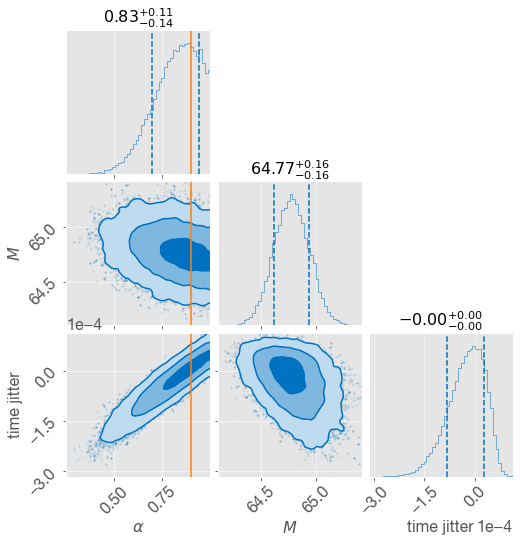

In [261]:
# Make a corner plot.
result.plot_corner()

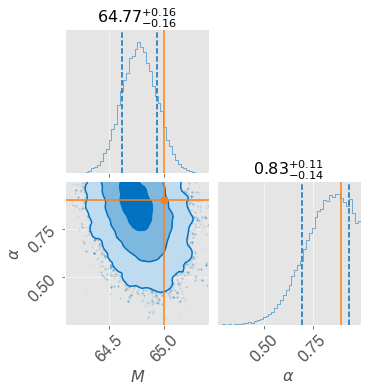

In [262]:
# Make a corner plot.
# result.plot_corner(truth=dict(chirp_mass=mchirp_inj, mass_ratio=q_inj, alpha=injection_parameters['alpha']))
result.plot_corner(truth=dict(total_mass=M_inj, alpha=injection_parameters['alpha']))

In [263]:
result.posterior['alpha']

0        0.813622
1        0.813622
2        0.793393
3        0.780416
4        0.781855
           ...   
99995    0.942115
99996    0.878901
99997    0.878901
99998    0.849952
99999    0.843116
Name: alpha, Length: 100000, dtype: float64

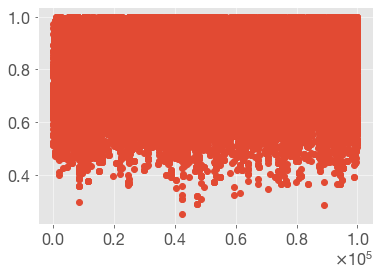

In [264]:
plt.figure()
plt.plot(result.posterior['alpha'], 'o')
# plt.xlim(0, 500)

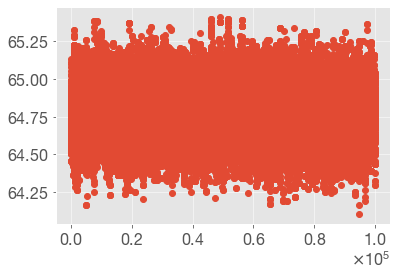

In [265]:
plt.figure()
plt.plot(result.posterior['total_mass'], 'o')
# plt.xlim(0, 500)

# PE run cases

In [7]:
# try to reproduce the grid based approach from before
# but a bit different maybe
# injection: 

# SEOBNRv4

# snr = 50
# delta_t = 1/4096.
# f_lower = 20.

# mtot_true = 100
# q_true = 4
# mass1_true, mass2_true = 80., 20. 
# spin1z_true = 0.9
# spin2z_true = 0.9

# case 1: IMRPhenomD
# case 2: IMRPhenomC
# case 3: mixed(PhenomC, PhenomD)

In [9]:
def run_cases(label):
    # Set the duration and sampling frequency of the data segment that we're
    # going to inject the signal into
    duration = 4.
    sampling_frequency = 2048.
    # sampling_frequency = 1024.
#     sampling_frequency = 512.

    minimum_frequency=20.

    # Specify the output directory and the name of the simulation.
    outdir = 'mixed_generator_output'
    bilby.core.utils.setup_logger(outdir=outdir, label=label)
    
    # We are going to inject a binary black hole waveform.  We first establish a
    # dictionary of parameters that includes all of the different waveform
    # parameters, including masses of the two black holes (mass_1, mass_2),
    # spins of both black holes (a, tilt, phi), etc.
    injection_parameters = dict(
        mass_1=80., mass_2=20., a_1=0.85, a_2=0.85, tilt_1=0., tilt_2=0,
        phi_12=0, phi_jl=0., luminosity_distance=600., theta_jn=0., psi=0,
        phase=0, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)
    
    # Fixed arguments passed into the source model
    waveform_arguments = dict(
        waveform_approximant='SEOBNRv4',
        reference_frequency=50., minimum_frequency=minimum_frequency
    )
    
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
#         frequency_domain_source_model=mixed_lal_binary_black_hole,    
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments)
    
    
    # Set up interferometers.  In this case we'll use two interferometers
    # (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
    # sensitivity
#     ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
    ifos = bilby.gw.detector.InterferometerList(['H1'])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameters['geocent_time'] - 3)


    for ifo in ifos:
        ifo.minimum_frequency = minimum_frequency


    ifos.inject_signal(waveform_generator=waveform_generator,
                       parameters=injection_parameters)
    
    mchirp_inj = pycbc.conversions.mchirp_from_mass1_mass2(injection_parameters['mass_1'], injection_parameters['mass_2'])
    
    q_inj = injection_parameters['mass_2'] / injection_parameters['mass_1']
    M_inj = injection_parameters['mass_2'] + injection_parameters['mass_1']
    
    priors = bilby.gw.prior.BBHPriorDict()
    priors['geocent_time'] = bilby.core.prior.Uniform(
        minimum=injection_parameters['geocent_time'] - 1,
        maximum=injection_parameters['geocent_time'] + 1,
        name='geocent_time', latex_label='$t_c$', unit='$s$')
    priors['phase'] = bilby.core.prior.Uniform(-np.pi / 2, np.pi / 2, r'$\phi$')
    
    if label == 'case3':
        priors['alpha'] = bilby.core.prior.Uniform(0, 1, r'$\alpha$')

    for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'dec', 'theta_jn', 'luminosity_distance']:
        priors[key] = injection_parameters[key]

    # priors['mass_1'] = injection_parameters['mass_1']
    # priors['mass_2'] = injection_parameters['mass_2']
    # priors['chirp_mass'] = mchirp_inj


    priors.pop('mass_1')
    priors.pop('mass_2')
    priors.pop('mass_ratio')
    priors.pop('chirp_mass')

    priors['mass_ratio'] = q_inj
    priors['total_mass'] = bilby.core.prior.Uniform(80, 120, r'$M$')
    
    
    # setting up the waveform generator for the sampler
    if label == 'case1':
        # Fixed arguments passed into the source model
        waveform_arguments = dict(
            waveform_approximant='IMRPhenomD',
            reference_frequency=50., minimum_frequency=minimum_frequency,
        )
        # Create the waveform_generator using a LAL BinaryBlackHole source function
        waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration, sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
#             frequency_domain_source_model=mixed_lal_binary_black_hole,    
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments)
        

    elif label == 'case2':
        # Fixed arguments passed into the source model
        waveform_arguments = dict(
            waveform_approximant='IMRPhenomC',
            reference_frequency=50., minimum_frequency=minimum_frequency,
        )
        # Create the waveform_generator using a LAL BinaryBlackHole source function
        waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration, sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
#             frequency_domain_source_model=mixed_lal_binary_black_hole,    
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments)
    
    elif label == 'case3':
        # Fixed arguments passed into the source model
        waveform_arguments = dict(
            waveform_approximant='IMRPhenomC',
            reference_frequency=50., minimum_frequency=minimum_frequency,
            waveform_approximant_2 = "IMRPhenomD"
        )
        
        # Create the waveform_generator using a LAL BinaryBlackHole source function
        waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration, sampling_frequency=sampling_frequency,
        #     frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            frequency_domain_source_model=mixed_lal_binary_black_hole,    
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments)    
    
    
    
    # Initialise the likelihood by passing in the interferometer data (ifos) and
    # the waveform generator
    likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, waveform_generator=waveform_generator, phase_marginalization=True, time_marginalization=True, priors=priors)

    # likelihood = bilby.gw.GravitationalWaveTransient(
    #     interferometers=ifos, waveform_generator=waveform_generator, phase_marginalization=True, priors=priors)

    # likelihood = bilby.gw.GravitationalWaveTransient(
    #     interferometers=ifos, waveform_generator=waveform_generator, time_marginalization=True, priors=priors)

    # likelihood = bilby.gw.GravitationalWaveTransient(
    #     interferometers=ifos, waveform_generator=waveform_generator)
    
    # Run sampler.  In this case we're going to use the `dynesty` sampler
    result = bilby.run_sampler(
        likelihood=likelihood, priors=priors, sampler='dynesty', npoints=512,
        injection_parameters=injection_parameters, outdir=outdir, label=label)


#     result = bilby.run_sampler(
#         likelihood=likelihood, priors=priors, sampler='emcee',
#         nwalkers=100, nsteps=500, nburn=100, npool=4,
#         injection_parameters=injection_parameters, outdir=outdir, label=label)
    
    
    # Make a corner plot.
    result.plot_corner()
    
    return result

In [10]:
result_case1 = run_cases(label='case1')

12:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
/Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:23 bilby INFO    : Injected signal in H1:
12:23 bilby INFO    :   optimal SNR = 52.89
12:23 bilby INFO    :   matched filter SNR = 52.85-1.78j
12:23 bilby INFO    :   mass_1 = 80.0
12:23 bilby INFO    :   mass_2 = 20.0
12:23 bilby INFO    :   a_1 = 0.85
12:23 bilby INFO    :   a_2 = 0.85
12:23 bilby INFO    :   tilt_1 = 0.0
12:23 bilby INFO    :   tilt_2 = 0
12:23 bilby INFO    :   phi_12 = 0
12:23 bilby INFO    :   phi_jl = 0.0
12:23 bilby INFO    :   luminosity_distance = 600.0
12:23 bilby 

0it [00:00, ?it/s]

12:23 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 512, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 307, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x14156ed50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:23 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:23 bilby INFO    : Using dynesty version 1.1
12:23 bilby INFO    : Using the bilby-implemented rwalk sample me

12:32 bilby INFO    : Sampling time: 0:09:44.904282
12:32 bilby INFO    : Summary of results:
nsamples: 4955
ln_noise_evidence: -5363.829
ln_evidence: -4002.031 +/-  0.144
ln_bayes_factor: 1361.798 +/-  0.144



In [11]:
result_case2 = run_cases(label='case2')

12:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
/Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:32 bilby INFO    : Injected signal in H1:
12:32 bilby INFO    :   optimal SNR = 52.89
12:32 bilby INFO    :   matched filter SNR = 51.09-0.39j
12:32 bilby INFO    :   mass_1 = 80.0
12:32 bilby INFO    :   mass_2 = 20.0
12:32 bilby INFO    :   a_1 = 0.85
12:32 bilby INFO    :   a_2 = 0.85
12:32 bilby INFO    :   tilt_1 = 0.0
12:32 bilby INFO    :   tilt_2 = 0
12:32 bilby INFO    :   phi_12 = 0
12:32 bilby INFO    :   phi_jl = 0.0
12:32 bilby INFO    :   luminosity_distance = 600.0
12:32 bilby 

0it [00:00, ?it/s]

12:32 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 512, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 307, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x141d32110>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:32 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:32 bilby INFO    : Using dynesty version 1.1
12:32 bilby INFO    : Using the bilby-implemented rwalk sample me

12:43 bilby INFO    : Sampling time: 0:10:03.018932
12:43 bilby INFO    : Summary of results:
nsamples: 4932
ln_noise_evidence: -5399.627
ln_evidence: -4186.998 +/-  0.143
ln_bayes_factor: 1212.629 +/-  0.143



In [12]:
result_case3 = run_cases(label='case3')

12:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
/Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:43 bilby INFO    : Injected signal in H1:
12:43 bilby INFO    :   optimal SNR = 52.89
12:43 bilby INFO    :   matched filter SNR = 53.05-0.31j
12:43 bilby INFO    :   mass_1 = 80.0
12:43 bilby INFO    :   mass_2 = 20.0
12:43 bilby INFO    :   a_1 = 0.85
12:43 bilby INFO    :   a_2 = 0.85
12:43 bilby INFO    :   tilt_1 = 0.0
12:43 bilby INFO    :   tilt_2 = 0
12:43 bilby INFO    :   phi_12 = 0
12:43 bilby INFO    :   phi_jl = 0.0
12:43 bilby INFO    :   luminosity_distance = 600.0
12:43 bilby 

0it [00:00, ?it/s]

12:43 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 512, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 307, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1044147d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:43 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:43 bilby INFO    : Using dynesty version 1.1
12:43 bilby INFO    : Using the bilby-implemented rwalk sample me

13:15 bilby INFO    : Sampling time: 0:32:15.438549
13:15 bilby INFO    : Summary of results:
nsamples: 7058
ln_noise_evidence: -5413.729
ln_evidence: -4042.413 +/-  0.187
ln_bayes_factor: 1371.316 +/-  0.187



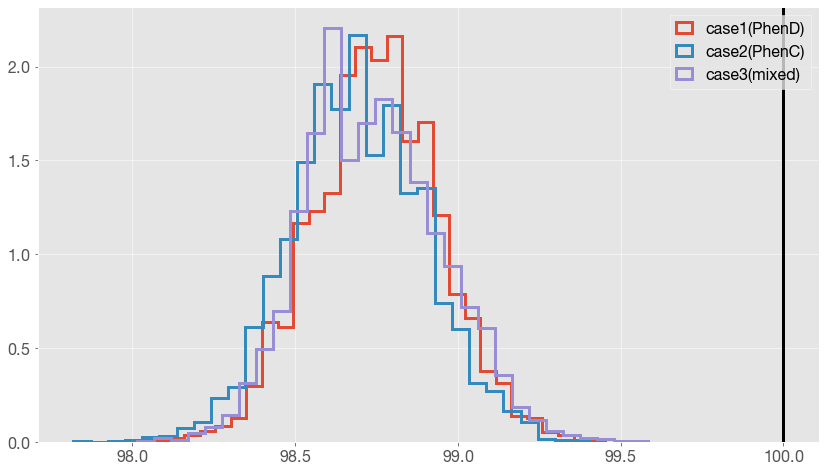

In [22]:
plt.figure(figsize=(14, 8))
plt.hist(result_case1.posterior['total_mass'], label='case1(PhenD)', histtype='step', density=True, lw=3, bins=30);
plt.hist(result_case2.posterior['total_mass'], label='case2(PhenC)', histtype='step', density=True, lw=3, bins=30);
plt.hist(result_case3.posterior['total_mass'], label='case3(mixed)', histtype='step', density=True, lw=3, bins=30);
plt.axvline(100, c='k', lw=3)
plt.legend()

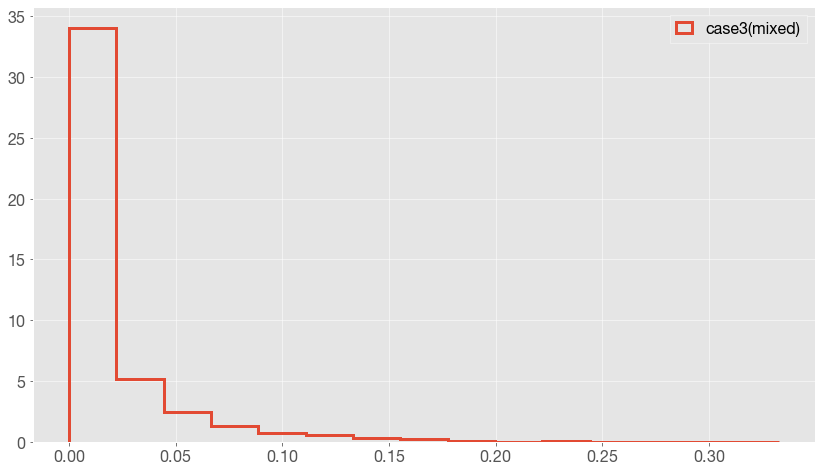

In [16]:
plt.figure(figsize=(14, 8))
plt.hist(result_case3.posterior['alpha'], label='case3(mixed)', histtype='step', density=True, lw=3, bins=15);
# plt.axvline(100, c='k', lw=3)
plt.legend()

In [17]:
from scipy.stats import gaussian_kde
def estimate_kde_pdf(y):
    kde = gaussian_kde(y)

    xmin = np.min(y)
    xmax = np.max(y)

    npts_sample = int(1e3)
    x = np.linspace(xmin, xmax, npts_sample)
    kde_pdf = kde.evaluate(x)
    
    return x, kde_pdf

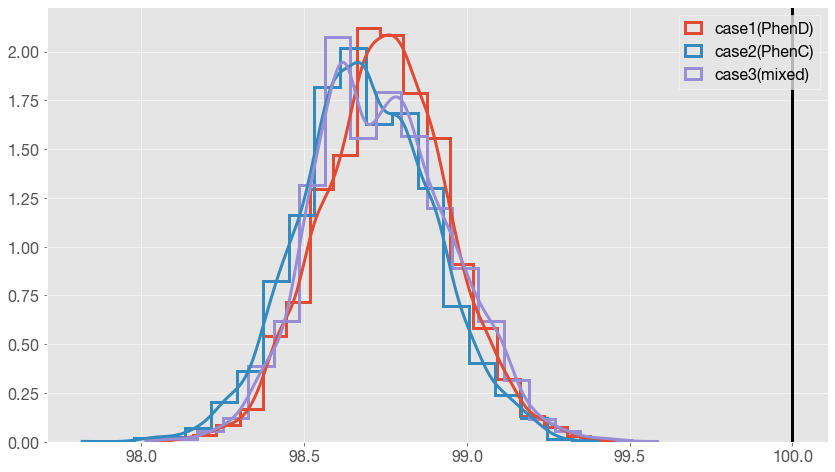

In [25]:


plt.figure(figsize=(14, 8))
plt.hist(result_case1.posterior['total_mass'], label='case1(PhenD)', histtype='step', density=True, lw=3, bins=20);
plt.hist(result_case2.posterior['total_mass'], label='case2(PhenC)', histtype='step', density=True, lw=3, bins=20);
plt.hist(result_case3.posterior['total_mass'], label='case3(mixed)', histtype='step', density=True, lw=3, bins=20);

plt.plot(*estimate_kde_pdf(result_case1.posterior['total_mass']), c='C0', lw=3)
plt.plot(*estimate_kde_pdf(result_case2.posterior['total_mass']), c='C1', lw=3)
plt.plot(*estimate_kde_pdf(result_case3.posterior['total_mass']), c='C2', lw=3)

plt.axvline(100, c='k', lw=3)
plt.legend()